# Linear regression example

This tutorial demonstrates the application of linear regression to test for QTL associations.

### Set up the environment

In [3]:
%matplotlib inline
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

import sys
import numpy as np
import scipy as sp
import scipy.stats as st
import pylab as pl
import pandas as pd
import h5py
sp.random.seed(0)

import limix.util as lmx_util
import limix.plot as lmx_plt

### Load the data

Here, we load the yeast cross dataset.
The data used in this study have already been converted into an hdf5 file. 
To process your own data, please use the limix command line binary (see [here](http://nbviewer.jupyter.org/github/limix/limix-tutorials/blob/master/preprocessing_QC/loading_files.ipynb)).

In [4]:
sys.path.append('./..')
import data as tutorial_data
file_name = tutorial_data.get_file('BYxRM')

### Set up the data object

Both the phenotypes and the genotypes are stored inside an HDF5 file. Load the data into a dataframe; here, we focus on the first 3 phenotypes. 

In [15]:
f = h5py.File(file_name, 'r')
pheno_group = f['phenotype']
pheno_df = pd.DataFrame(pheno_group['matrix'][:], 
                        columns=np.char.decode(pheno_group['col_header']['phenotype_ID'][:]),
                        index=np.char.decode(pheno_group['row_header']['sample_ID'][:]))

In [16]:
pheno_df.head()

,Cadmium_Chloride,Caffeine,Calcium_Chloride,Cisplatin,Cobalt_Chloride,Congo_red,Copper,Cycloheximide,Diamide,E6_Berbamine,...,x6-Azauracil,Xylose,YNB,YNB:ph3,YNB:ph8,YPD,YPD:15C,YPD:37C,YPD:4C,Zeocin
A01_01,-7.323520,0.279993,0.313118,1.658179,-1.604442,5.841617,-4.130950,0.821226,3.622602,-0.378747,...,1.199054,-0.309149,17.470822,0.055225,-0.184268,24.548971,0.712171,0.890842,4.118372,8.592818
A01_02,-8.098236,-0.206326,-0.534844,-0.918012,0.892198,-1.618172,1.131947,-0.764736,-2.946279,-2.475193,...,0.443182,0.697908,18.052925,0.283462,1.662201,26.808476,-1.522498,0.006062,0.066515,-4.220476
A01_03,7.605720,-0.127960,-0.311102,-2.712088,3.301709,-6.680571,-1.138056,-3.382532,-3.157866,-4.178616,...,1.472629,1.474329,18.163782,-0.951379,0.369565,26.183975,1.082289,1.723157,5.714088,-6.506519
A01_04,-6.147649,0.878392,-0.563331,-0.827358,-1.291270,2.753851,-2.268121,0.867456,-6.832079,-1.970630,...,0.054694,-0.739040,15.575856,-1.690867,-0.840344,20.893646,-0.636280,0.053258,-3.196936,0.294462
A01_05,9.379060,-1.353169,0.405204,-1.137234,4.260286,-7.391216,-3.222742,1.586376,1.048391,-3.971730,...,0.267463,0.959138,17.808444,0.127621,1.967267,28.621507,-3.720999,-0.768724,-4.002786,7.045575


We want to concentrate on the first 3 phenotypes (remember phenotypes are stored in the columns

In [20]:
pheno_df = pheno_df[pheno_df.columns[:3]]
pheno_df.head()

,Cadmium_Chloride,Caffeine,Calcium_Chloride
A01_01,-7.323520,0.279993,0.313118
A01_02,-8.098236,-0.206326,-0.534844
A01_03,7.605720,-0.127960,-0.311102
A01_04,-6.147649,0.878392,-0.563331
A01_05,9.379060,-1.353169,0.405204


In [21]:
geno_group = f['genotype']
chromosomes = geno_group['col_header']['chrom'][:]
positions = geno_group['col_header']['pos'][:]
geno_df = pd.DataFrame(geno_group['matrix'][:], columns=positions, 
                       index=np.char.decode(geno_group['row_header']['sample_ID'][:]), dtype='int64')

In [22]:
geno_df.head()

,27915,28323,28652,29667,30756,31059,31213,31636,31756,31976,...,925487,925742,926177,927903,928103,929518,929724,930545,931289,931944
A01_01,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
A01_02,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
A01_03,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1
A01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A01_05,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [23]:
#Remove NaNs
filtered_pheno_df = pheno_df.dropna()
filtered_pheno_df.info()
sample_idx = geno_df.index.intersection(filtered_pheno_df.index)

<class 'pandas.core.frame.DataFrame'>
Index: 785 entries, A01_01 to A11_93
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cadmium_Chloride  785 non-null    float64
 1   Caffeine          785 non-null    float64
 2   Calcium_Chloride  785 non-null    float64
dtypes: float64(3)
memory usage: 24.5+ KB


In [24]:
#phenotype
phenotype_ID = pheno_df.columns.values
phenotype_vals = filtered_pheno_df

N = geno_df.shape[0] #number of individuals
S = geno_df.shape[1] #number of SNPs
P = phenotype_vals.shape[1]#number of phenotypes

# retrieve indices for filtered accessions

## Check the model assumptions (are the data normal?)

Here, we use histograms to look at the distributions of the phenotypes.

/Users/uemit.seren/miniconda3/envs/gwas-lecture/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 216x216 with 0 Axes>

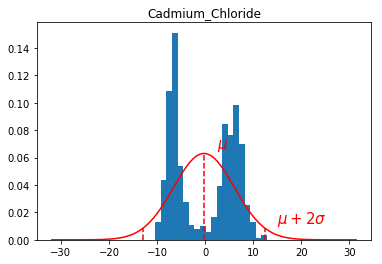

<Figure size 216x216 with 0 Axes>

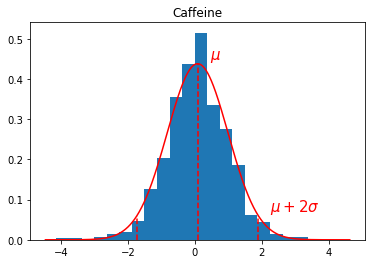

<Figure size 216x216 with 0 Axes>

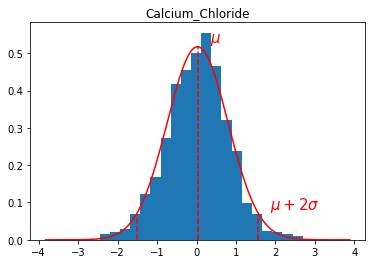

In [25]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[3,3])#create the figure
    
    #histogram of the untransformed phenotypes
    lmx_plt.plot_normal(phenotype_vals.values[:,ip])
    pl.title("%s" % p_ID)

Your data will often deviate from a normal distribution (sometimes drastically, like Cadmium Chloride shown above).
However, one of the assumptions of the model that we use in GWAS is that the residuals are normally distrbuted.
Violations of this assumption can result in model misspecification and biased parameter estimates.

### Variance stabilizing transformations; standardizing the phenotypes

There are a wide variety of methods to stabilize variance and make data normally distributed. Here, we explore the Box-Cox transformation as well as a (non-parametric) rank-based transformation.

#### Box-Cox transformation

The Box-Cox transformation makes the data "more normal" by fitting a power transformation ($y^{\lambda}$, where $\lambda$ is found using maximum likelihood) to the observed phenotypic data.

In [26]:
phenotype_vals_boxcox, maxlog = lmx_util.preprocess.boxcox(phenotype_vals.values)

#### Rank-based (non-parametric) transformation

The rank transformation normalizes the data by converting the data to ranks and then transforming these ranks to the corresponding quantiles of a normal distribution. Because this transformation does not rely on or specify a parameter it is considered non-parametric.

Before using a rank-based transformation, you should consider whether other models (e.g. the binomial model) are more appropriate for your data.

In [27]:
phenotype_vals_ranks = lmx_util.preprocess.rankStandardizeNormal(phenotype_vals.values)

Let's look at the histograms after transformation:

<Figure size 720x216 with 0 Axes>

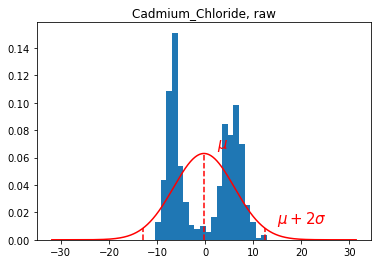

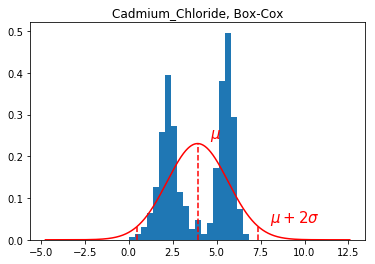

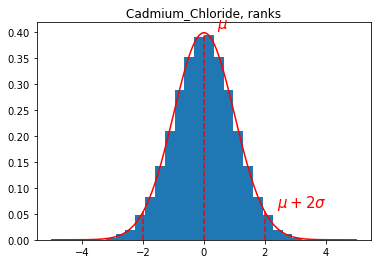

<Figure size 720x216 with 0 Axes>

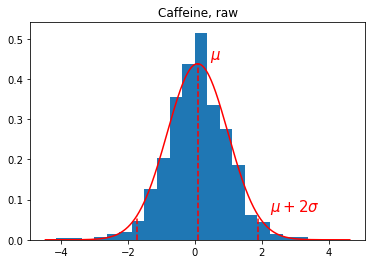

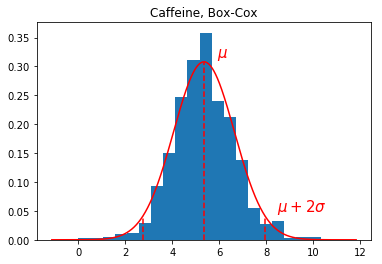

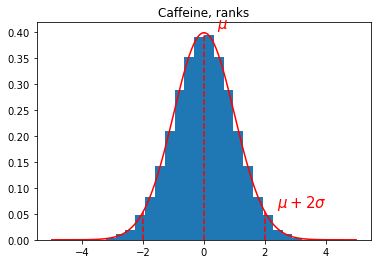

<Figure size 720x216 with 0 Axes>

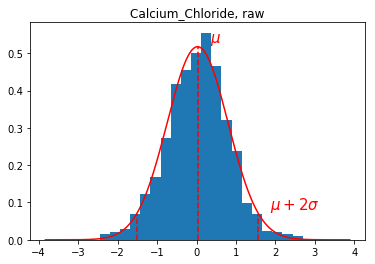

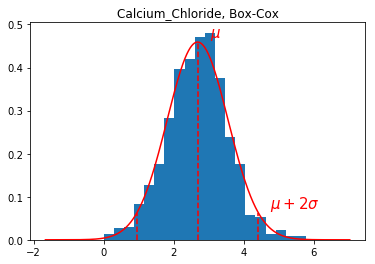

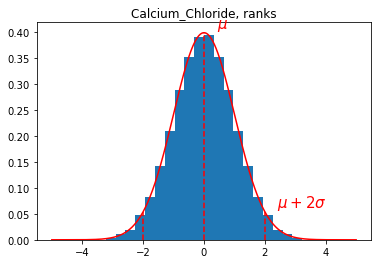

In [28]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])#create the figure
    
    #untransformed phenotypes
    lmx_plt.plot_normal(phenotype_vals.values[:,ip])
    pl.title("%s, raw" % p_ID)
    
    #boxcox-transformed phenotypes
    lmx_plt.plot_normal(phenotype_vals_boxcox[:,ip])
    pl.title("%s, Box-Cox" % p_ID)
    
    #the rank-normalized phenotypes
    lmx_plt.plot_normal(phenotype_vals_ranks[:,ip])
    pl.title("%s, ranks" % p_ID)

### GWAS using simple linear regression:

The function for linear regression in LIMIX is ``limix.qtl.qtl_test_lm`` (see [here](https://limix.readthedocs.io/en/stable/_modules/limix/qtl/qtl.html)). This approach works well for traits that aren't confounded with population structure (presumably, many defense-related traits).

In [29]:
from limix.qtl import qtl_test_lm

#run linear regression on each SNP
lm = qtl_test_lm(snps=geno_df.loc[sample_idx].values, pheno=phenotype_vals.values)
pv = lm.getPv() # get P values
beta = lm.getBetaSNP() # get effect sizes
beta_ste = lm.getBetaSNPste() # get standard errors

Next, we convert the P-values into a pandas DataFrame:

In [30]:
pvalues_lm = pd.DataFrame(pv.T, index=positions,
                          columns=phenotype_ID)
pvalues_lm.head()

,Cadmium_Chloride,Caffeine,Calcium_Chloride
27915,0.552389,0.921219,0.105373
28323,0.586922,0.903911,0.109003
28652,0.542816,0.950267,0.122746
29667,0.568640,0.840404,0.157083
30756,0.530018,0.894559,0.155157


### Plotting the results

A common way to visualize the results from GWAS is by using a so-called Manhattan plot, where the $-log_{10}$ P-values are plotted against the genomic position.

The LIMIX function for producing Manhattan plots is ``limix.plot.plot_manhattan`` (see [here][1]).

[1]:https://limix.readthedocs.io/en/stable/_modules/limix/plot/manhattan.html

In [31]:
def no_annotate(*args):
    pass
from limix.plot import manhattan
manhattan._annotate = no_annotate

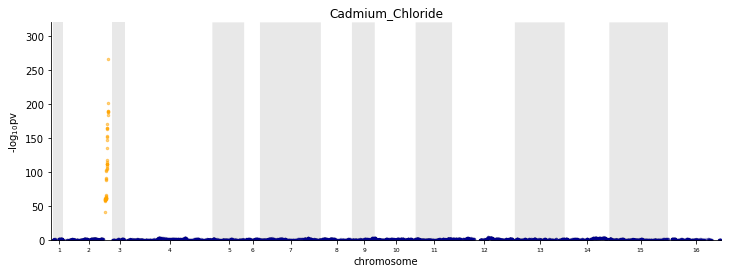

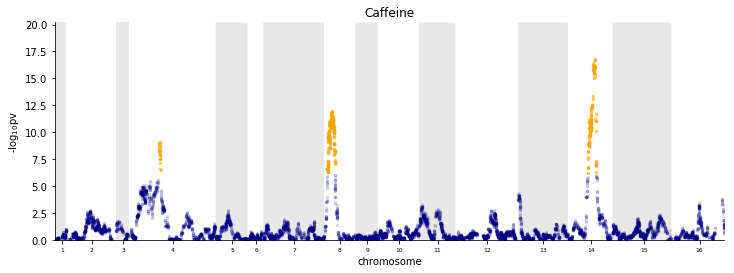

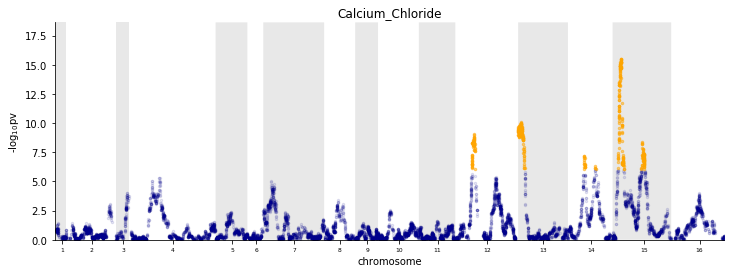

In [32]:
# Genome-wide manhatton plots for one phenotype:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[12,4])
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm[p_ID].values,chrom=chromosomes,pos=positions)))
    pl.title(p_ID)

### Observations:

* Several peaks are visible.

* The peaks entail multiple neighboring SNPs due to linkage disequilibrium to the causal variant. 

### Conducting GWAS with the transformed phenotypes:

Next, we perform GWAS with the Box-Cox transformed phenotypes.

In [33]:
#run linear regression on each SNP
lm_boxcox = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals_boxcox)
pv_boxcox = lm_boxcox.getPv()

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_boxcox = pd.DataFrame(data=pv_boxcox.T,index=positions,
                          columns=phenotype_ID)

Next, we investigate the rank-transformed phenotypes.

In [34]:
#run linear regression on each SNP
lm_ranks = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals_ranks)
pv_ranks = lm_ranks.getPv()

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_ranks = pd.DataFrame(data=pv_ranks.T,index=positions,
                          columns=phenotype_ID)

To compare the results of the transformations, we can plot the p-values against one another:

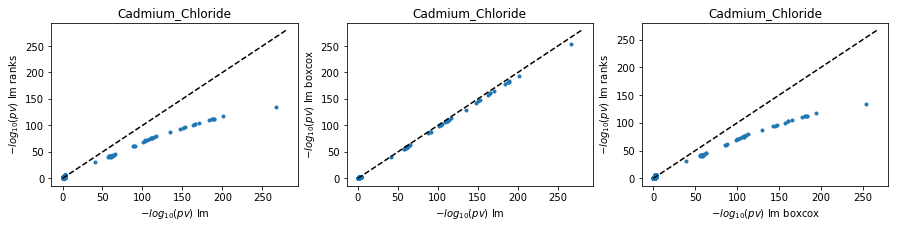

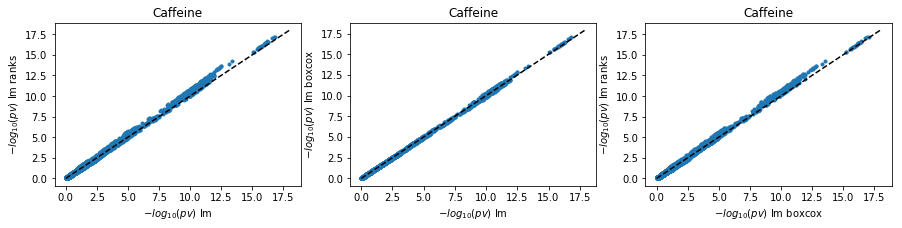

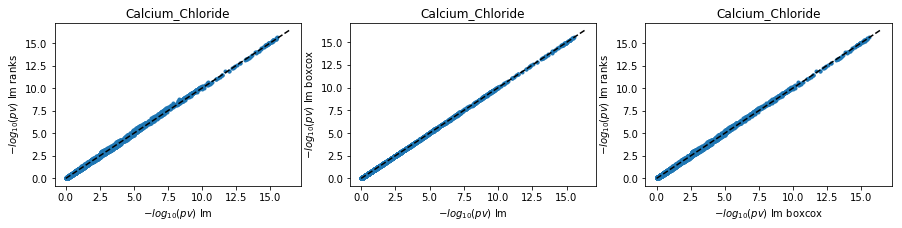

In [35]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[15,3])#create the figure
    pl.subplot(1,3,1)
    pl.plot(-np.lib.scimath.log10(pvalues_lm[p_ID].values),-np.lib.scimath.log10(pvalues_lm_ranks[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm')
    pl.ylabel('$-log_{10}(pv)$ lm ranks')
    pl.title(p_ID)
    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    pl.subplot(1,3,2)
    pl.plot(-np.lib.scimath.log10(pvalues_lm[p_ID].values),-np.lib.scimath.log10(pvalues_lm_boxcox[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm')
    pl.ylabel('$-log_{10}(pv)$ lm boxcox')
    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    pl.title(p_ID)
    pl.subplot(1,3,3)
    pl.plot(-np.lib.scimath.log10(pvalues_lm_boxcox[p_ID].values),-np.lib.scimath.log10(pvalues_lm_ranks[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm boxcox')
    pl.ylabel('$-log_{10}(pv)$ lm ranks')
    pl.title(p_ID)

    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    


Question:
* Can you speculate why the P-values from GWAS of (rank transformed) Cadmium Chloride are 'deflated'? Hint: look at the raw data.

Next, we look at how the phenotypes at the strongest associated SNPs differ among genotypes.

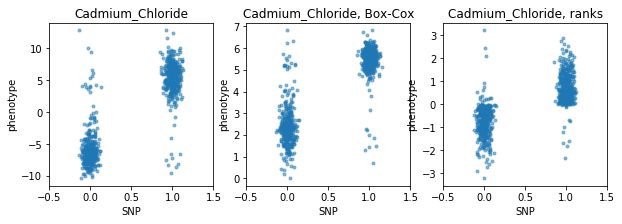

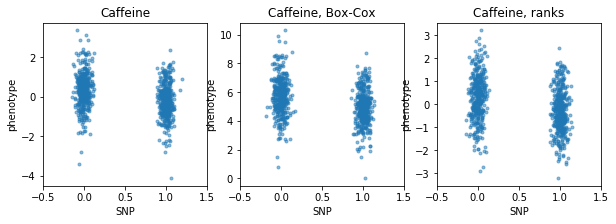

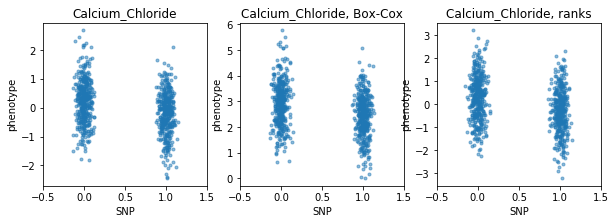

In [36]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])#create the figure
    
    plt = pl.subplot(1,3,1)#the untransformed phenotypes
    #find maximum squared beta value
    pheno_vals = filtered_pheno_df[p_ID]
    s_idx = geno_df.index.intersection(pheno_vals.index)
    
    imax = lm.pvalues[ip].argmin()
    #snp = geno_df.loc[s_idx][geno_df.columns[imax]]
    snp = geno_df.loc[sample_idx][geno_df.columns[imax]]

    #plot SNP vs. phenotype for max beta
    
    pl.plot(snp+0.05*np.random.randn(snp.shape[0]),pheno_vals.values,'.',alpha=0.5)
    
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s" % p_ID)

    plt = pl.subplot(1,3,2)#the Box-Cox transformed phenotypes
    pl.plot(snp+0.05*np.random.randn(snp.shape[0]),phenotype_vals_boxcox[:,ip],'.',alpha=0.5)
    
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s, Box-Cox" % p_ID)
    
    plt = pl.subplot(1,3,3)#the rank transformed phenotypes
    pl.plot(snp+0.05*np.random.randn(snp.shape[0]),phenotype_vals_ranks[:,ip],'.',alpha=0.5)
    
    #pl.plot([0,1],[pheno_vals.values[i_0].mean(),pheno_vals.values[~i_0].mean()])
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s, ranks" % p_ID)
    

## Assessing the P-value distribution

P-values corresponding to truly null hypotheses (that is, of no association) should be uniformly distributed between 0 and 1.

/Users/uemit.seren/miniconda3/envs/gwas-lecture/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


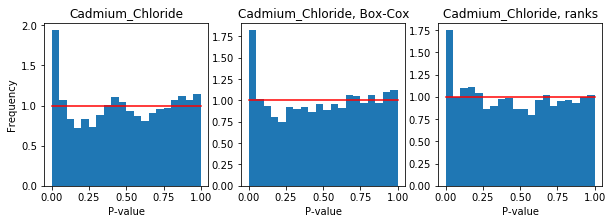

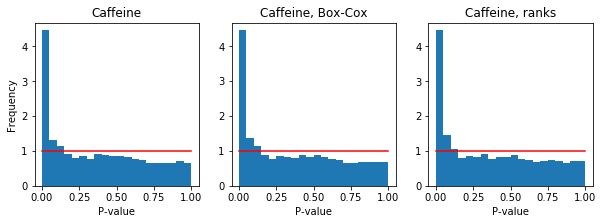

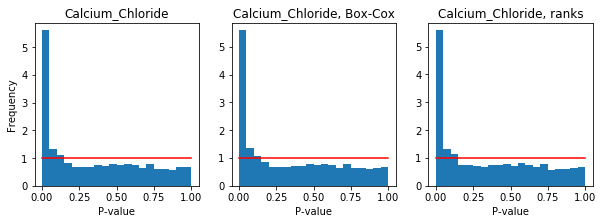

In [37]:
# P-value histgrams

for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])
    
    plt = pl.subplot(1,3,1)
    pl.hist(pvalues_lm[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s" % p_ID)
    pl.xlabel("P-value")
    pl.ylabel("Frequency")
    
    plt = pl.subplot(1,3,2)
    pl.hist(pvalues_lm_boxcox[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s, Box-Cox" % p_ID)
    pl.xlabel("P-value")
    
    plt = pl.subplot(1,3,3)
    pl.hist(pvalues_lm_ranks[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s, ranks" % p_ID)
    pl.xlabel("P-value")
    
    

Overall, these histograms show a large number of uniformly distributed P-values. However, there are also small P-values.

### P-value Quantile-Quantile plots

Comparing the quantiles of the negative log P-values to the negative log uniform quantiles, the excess number of small P-values becomes even more visible (see next section).

The function in LIMIX to produce QQ plots is ``limix.plot.qqplot`` (see [here][1]).

Question:

* How would you explain these non-uniform P-value distributions?

[1]:https://limix.readthedocs.io/en/stable/_modules/limix/plot/qqplot.html

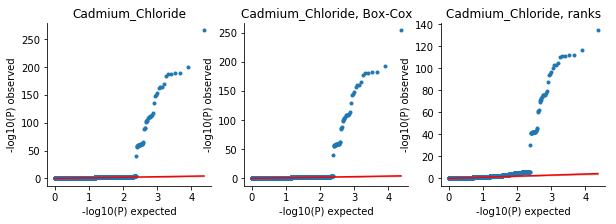

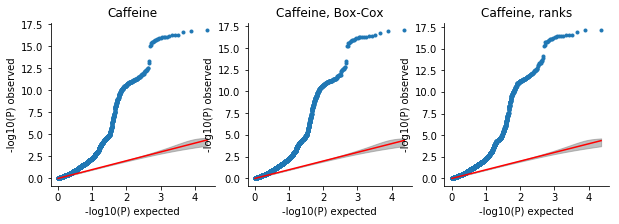

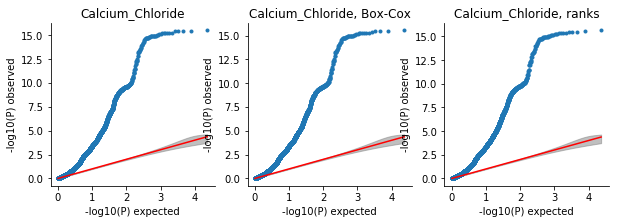

In [38]:
# Quantile-Quantile plots

for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])
    
    plt = pl.subplot(1,3,1)
    lmx_plt.qqplot(pvalues_lm[p_ID].values)
    pl.title("%s" % p_ID)
    
    plt = pl.subplot(1,3,2)
    lmx_plt.qqplot(pvalues_lm_boxcox[p_ID].values)
    pl.title("%s, Box-Cox" % p_ID)
    
    plt = pl.subplot(1,3,3)
    lmx_plt.qqplot(pvalues_lm_ranks[p_ID].values)
    pl.title("%s, ranks" % p_ID)
    

The grey area in the plots marks the $\alpha=0.01$ confidence interval for the hypothesis that a P-value comes from the null distribution.

## Permutation tests

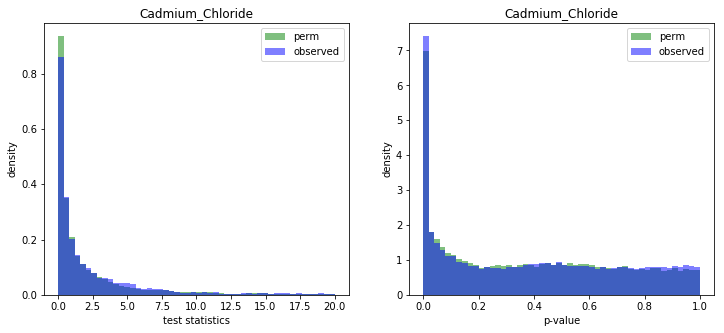

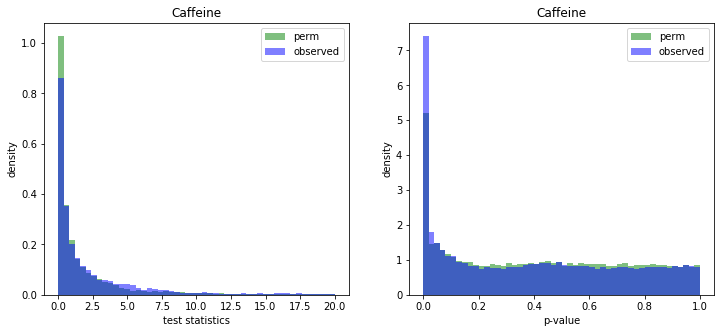

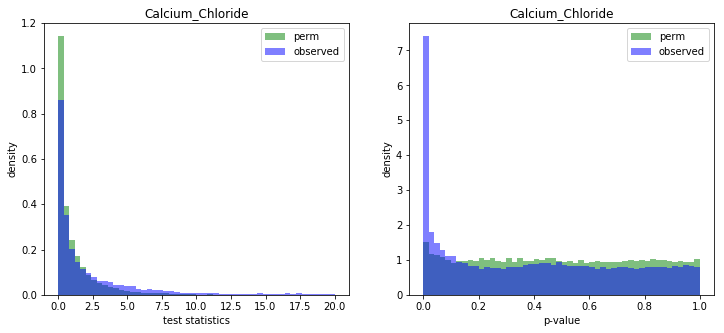

In [39]:
"""
computing test statistics on permuted data
"""
phenotype_vals_perm = phenotype_vals.copy()

for ip, p_ID in enumerate(phenotype_ID):
    perm = sp.random.permutation(phenotype_vals[p_ID].values)
    phenotype_vals_perm[p_ID] = perm
  
    #run linear regression on each SNP on permutated and non-permuted data
    lm = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals.values)
    lm_perm = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals_perm.values)
    
    #plot
    fig = pl.figure(figsize=[12,5])
    pl.subplot(1,2,1)
    pl.hist(lm_perm.test_statistics.flatten(),normed=True,color='g',alpha=0.5,bins=50,range=(0,20),label='perm')
    pl.hist(lm.test_statistics[1],normed=True,color='b',alpha=0.5,bins=50,range=(0,20),label='observed')
    pl.xlabel('test statistics')
    pl.ylabel('density')
    pl.title(p_ID)

    pl.legend()
    pl.subplot(1,2,2)
    p=pl.hist(lm_perm.pvalues.flatten(),normed=True,color='g',alpha=0.5,bins=50,range=(0,1),label='perm')
    p=pl.hist(lm.pvalues.flatten(),normed=True,color='b',alpha=0.5,bins=50,range=(0,1),label='observed')
    pl.title(p_ID)
    pl.xlabel('p-value')
    pl.ylabel('density')
    pl.legend()

## False discovery rates

False discovery rates (FDR) give an idea of the expected type-1 error rate at a given *P*-value threshold. This measure gives a useful alternative to traditional Bonferroni correction, which bounds the so-called family-wise error rate (FWER), namely the probability of having at least a single type-1 error.

That is, a *P* value is the rate at which truly null hypotheses are called significant.

The FDR is the rate that which significant results are truly null. So an FDR rate of 5% means that - among all of the features that are called significant - 5% of these will be false positives.

#### $q$-values

These are, like _P_ values, a measure of significance for a given test. 

In practice, if one is willing to accept a result at an FDR of the given $q$ value (e.g. 0.03) then among the results that have a lower $q$ value, $q$ percent of those will be false positives (3% in this example).

In the following we are computing $q$-values for each SNP first on the original data and then on permuted data. By permuting the data we break any dependence between the SNP and the phenotype, making the data come from the null distribution (no association).

The limix function to compute q-values is ``limix.stats.qvalues`` (see [here](https://limix.readthedocs.io/en/stable/stats.html#limix.stats.qvalues)).

(0, 10)

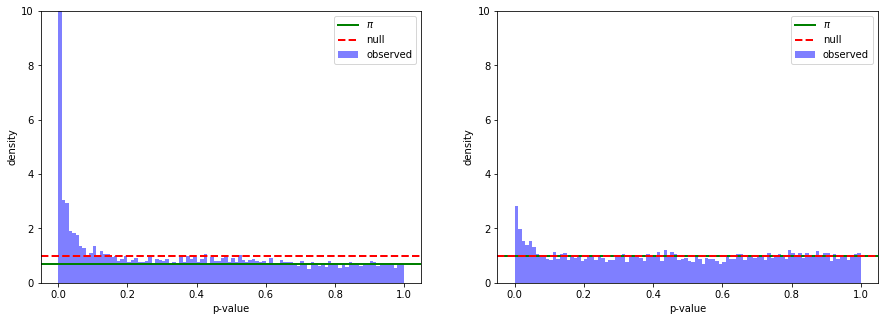

In [40]:
from limix.stats import qvalues
fig = pl.figure(3,figsize=[15,5])

#1. on the real tests
pl.subplot(1,2,1)
qv, pi0 = qvalues(lm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
fig = pl.figure(3,figsize=[8,5])
pl.hist(lm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))

#2. on permuted p-values
pl.subplot(1,2,2)
qv_perm, pi0 = qvalues(lm_perm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
pl.hist(lm_perm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))

To compare the differences and similarities between multiple hypothesis correctin via the false discovery rate and the family-wise error rate, we plot q-values (estimated by the Benjamini and Hochberg procedure) and the family-wise error rate (upper bounded by the Bonferoni method)

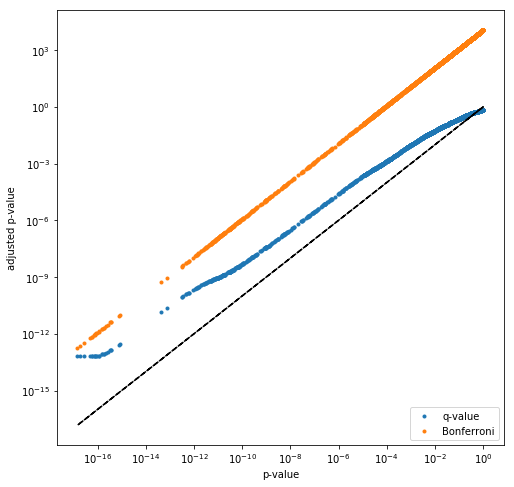

In [41]:
# compare q-values against p-values and Bonferroni adjustement:
pl.figure(figsize=[8,8])
pl.plot((lm.pvalues[1]),(qv),'.',label = 'q-value')
pl.plot((lm.pvalues[1]),(lm.pvalues[1]*geno_df.shape[1]),'.',label = 'Bonferroni')
pl.plot(lm.pvalues[1],lm.pvalues[1],'k--')
pl.yscale("log")
pl.xscale("log")
pl.xlabel('p-value')
pl.ylabel('adjusted p-value')
pl.legend(loc='lower right')

An interesting observation is that for a single significant SNP, the false discovery rate and the family-wise error rate are the same; they start to differ when lowering the significance threshold.

### Conditional analysis

For the phenotype Cadmium Chloride there was one very large effect visible. In the section below, we perform a conditional analysis to find additional secondary associations.

Note that all of the phenotypes condition on the same SNP, which has an association to the first phenotype only.

In [42]:
#create a matrix of covariates, one being the SNP to condition on 
#and a constant vector of ones representing the bias term.
imax = lm.pvalues[0].argmin()

covars_conditional= np.concatenate((geno_df.loc[sample_idx].values[:,imax:imax+1], np.ones((phenotype_vals.values.shape[0],1))),1)
                                  

#run linear regression on each SNP, while conditioning on the top SNP as a covariate.
lm_conditional = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals.values,covs=covars_conditional)

#convert P-values to a pandas DataFrame:
pvalues_lm_conditional = pd.DataFrame(data=lm_conditional.pvalues.T,index=positions,
                       columns=phenotype_ID)

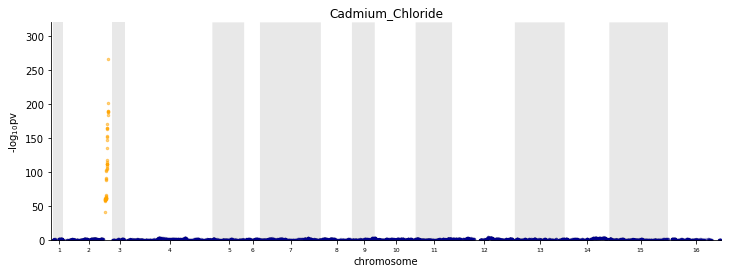

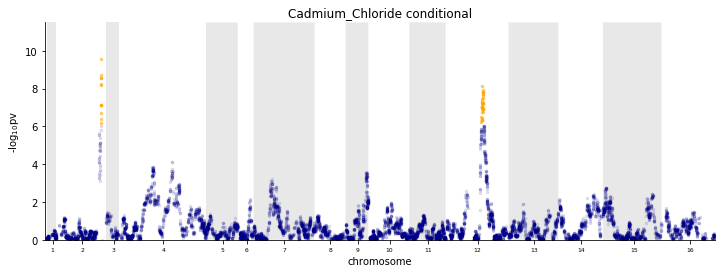

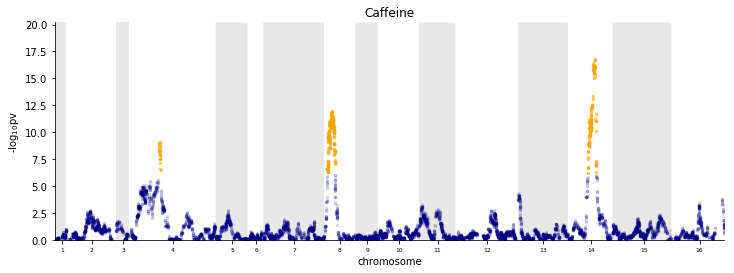

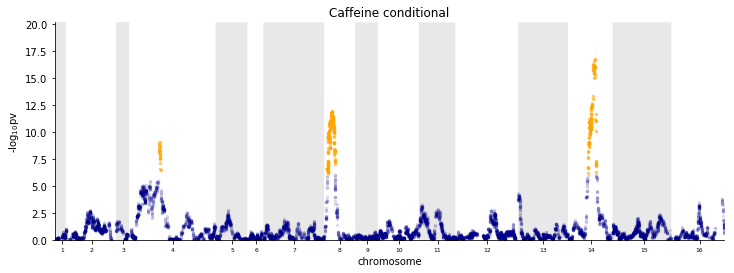

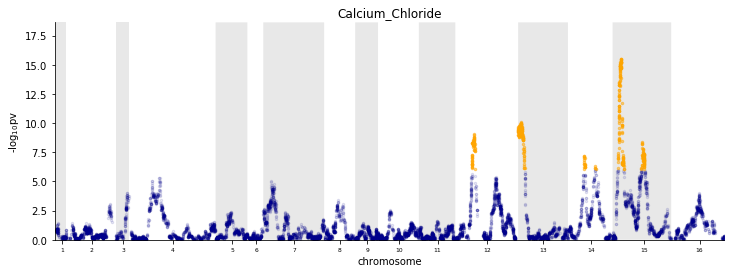

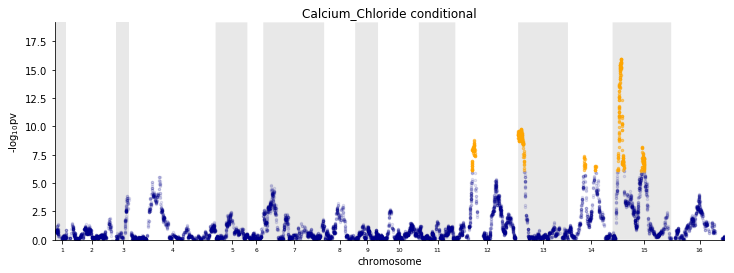

In [43]:
for ip, p_ID in enumerate(phenotype_ID):

    # before conditioninng
    pl.figure(figsize=[12,4])
    pl.title(p_ID)
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm[p_ID].values,chrom=chromosomes,pos=positions)))

    # after conditioning
    pl.figure(figsize=[12,4])
    pl.title(p_ID+" conditional")
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm_conditional[p_ID].values,chrom=chromosomes,pos=positions)))
    

Observation: For all but the associated phenotype the conditional analysis looks almost identical to the original analysis.